# Figures and computational analyses for Jankowski et al.
This Notebook contains code to recreate figures:
* S1A 
* 3A-C
* S2A-B
* S3A
* 4D

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib
import seaborn as sns
import random
from localcider.sequenceParameters import SequenceParameters
import protfasta
from scipy.stats import gaussian_kde

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# Set font to arial
font = {'family' : 'arial'}
matplotlib.rc('font', **font)

## FRQ sliding feature plots
* Supplemental Figs 1A
* Main text Figs 3A

In [2]:
# Import dataset
dataset = 'data/peptide_binding_data.csv'
df = pd.read_csv(dataset)

# Focus on 3-shift scanning peptides
shift3 = df[df['seq_type'] == '3-shift']

In [3]:
# Get N- and C-terminal residue number for each peptide
shift3.loc[:, 'NTD'] = shift3.loc[:, 'idx']*3 - 2
shift3.loc[:, 'CTD'] = shift3.loc[:, 'idx']*3 + 12
shift3.loc[318, 'CTD'] = 989 # Manually change last peptide since it's only 14aa

# Get average binding score of each peptide that overlaps every position
avg_binding = []
for i in range(1, 990):
    peptides = shift3[shift3['NTD'] <= i]
    peptides = peptides[peptides['CTD'] >= i]
    avg_binding.append(np.mean(peptides['avg']))

/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
domain = np.arange(1, 990)
FRQ = 'MADSGDKSQGMRPPPFDSRGHPLPRRASPDKSITLENHRLARDTSSRVTSSSALGVTESQPQLKSSPTRRNSSGESEPTNWFNQSNRNPAAAFHDESHIMEVDPPFYQKETDSSNEESRYPPGRNPVHPPGGVQLPGFRPVAAHSSAADDYRSVIDDLTVENKRLKEELKRYKQFGSDVMRKEKLFEIKVHGLPRRKKRELEATLRDFAASLGDSSESTSQRRKTGRHGTAVHSSGVSLSKHDSSSSSRSRPVDSAYNSMSTGRSSHAPHSSGPSLGRPSLTRAKSVGTQKVENYLRDTPDGLLPHHIVMTDKEKKKLVVRRLEQLFTGKISGRNMQRNQSMPSMDAPLAPEGTNMAPPRPPPEGLREACIQLQDGDNPRKNRSSKDNGSASNSGGDQTELGGTGTGSGDGSGSGGRTGNNTSPPGAIAPDQRPTRPRDLDPDRVQIPSENMDYIRHLGLVSPEFLQGSRTSYQDVAPDAEGWVYLNLLCNLAQLHMVNVTPSFIRQAVSEKSTKFQLSADGRKIRWRGGTDGTKFSSDSSEDKSQQSPMTEDTEDGSDKNGRRKKRKTQQASSEIGRFGPSRSPSDTFHYKPMFVHRNSSSIETSLEESMSQGSEDAVDESNMGNSKWDFSGSGTTQQRRKRRYDGAIVYYTGAPFCTDLSGDPGDMSPTAQMTAGREVEGSGSGDEVEHVLQRTLSGSSLPIRPLSDDRARVAEVLDFDPGNPPELVADDGSSPNDEDFVFPWCEDPAKVRIQPIAKEVMEPSGLGGVLPDDHFVMLVTTRRVVRPILQRQLSRSTTSEDTAEFIAERLAAIRTSSPLPPRSHRLTVAPLQVEYVSGQFRRLNPAPLPPPAIFYPPFSTDSSWDDGDDLASDDEEVEEVEEDSYSEGQISRRANPHFSDNNTYMRKDDLAFDTETDVRMDSDDNRLSDSGHNMRAMMPRAEAVDGDDSPLAAVTGKEVDMLHTGSSVATAGGAESGYSSSMEDVSSS'

In [6]:
# KD hydropathy:
def sliding_window_KDhydropathy(seq, window_size):
    KD_SCALE = {'A':1.8, 'C':2.5, 'D':-3.5, 'E':-3.5, 'F':2.8, 
                'G':-0.4, 'H':-3.2, 'I':4.5, 'K':-3.9, 'L':3.8,
                'M':1.9, 'N':-3.5, 'P':-1.6, 'Q':-3.5, 'R':-4.5, 
                'S':-0.8, 'T':-0.7, 'V':4.2, 'W':-0.9, 'Y':-1.3}

    seq_hp = []
    for aa in seq:
        seq_hp.append(KD_SCALE[aa])
    seq_hp = np.array(seq_hp)

    windows = []
    sides = int((window_size-1)/2)
    for i in range(len(seq)):
        if i < sides:
            window = seq_hp[0:(i+sides+1)]
        elif i >= len(seq) - sides:
            window = seq_hp[(i-sides):]
        else:
            window = seq_hp[(i-sides):(i+sides+1)]
        windows.append(np.sum(window)/window_size)
    return np.array(windows)

In [8]:
# Conservation
# TODO copy method over from housetools
from housetools.sequence_tools import sequence_conservation

wt_id = 'sp|P19970|FRQ_NEUCR Frequency clock protein OS=Neurospora crassa (strain ATCC 24698 / 74-OR23-1A / CBS 708.71 / DSM 1257 / FGSC 987) OX=367110 GN=f'
al = protfasta.read_fasta('../data/aligned.fasta', alignment=True)

C = sequence_conservation.ConservationCalculator()
b = C.calculate_conservation(al, target=wt_id, mode='property entropy', gap_cutoff=0.99)



In [11]:
# Disorder (metapredict)
import metapredict as meta

# Direct disorder
disorder = meta.predict_disorder(FRQ)
smooth_disorder = np.convolve(disorder, [0.2]*5, 'same')

# Fix boundaries
smooth_disorder[:2] = disorder[:2]
smooth_disorder[-2:] = disorder[-2:]

/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


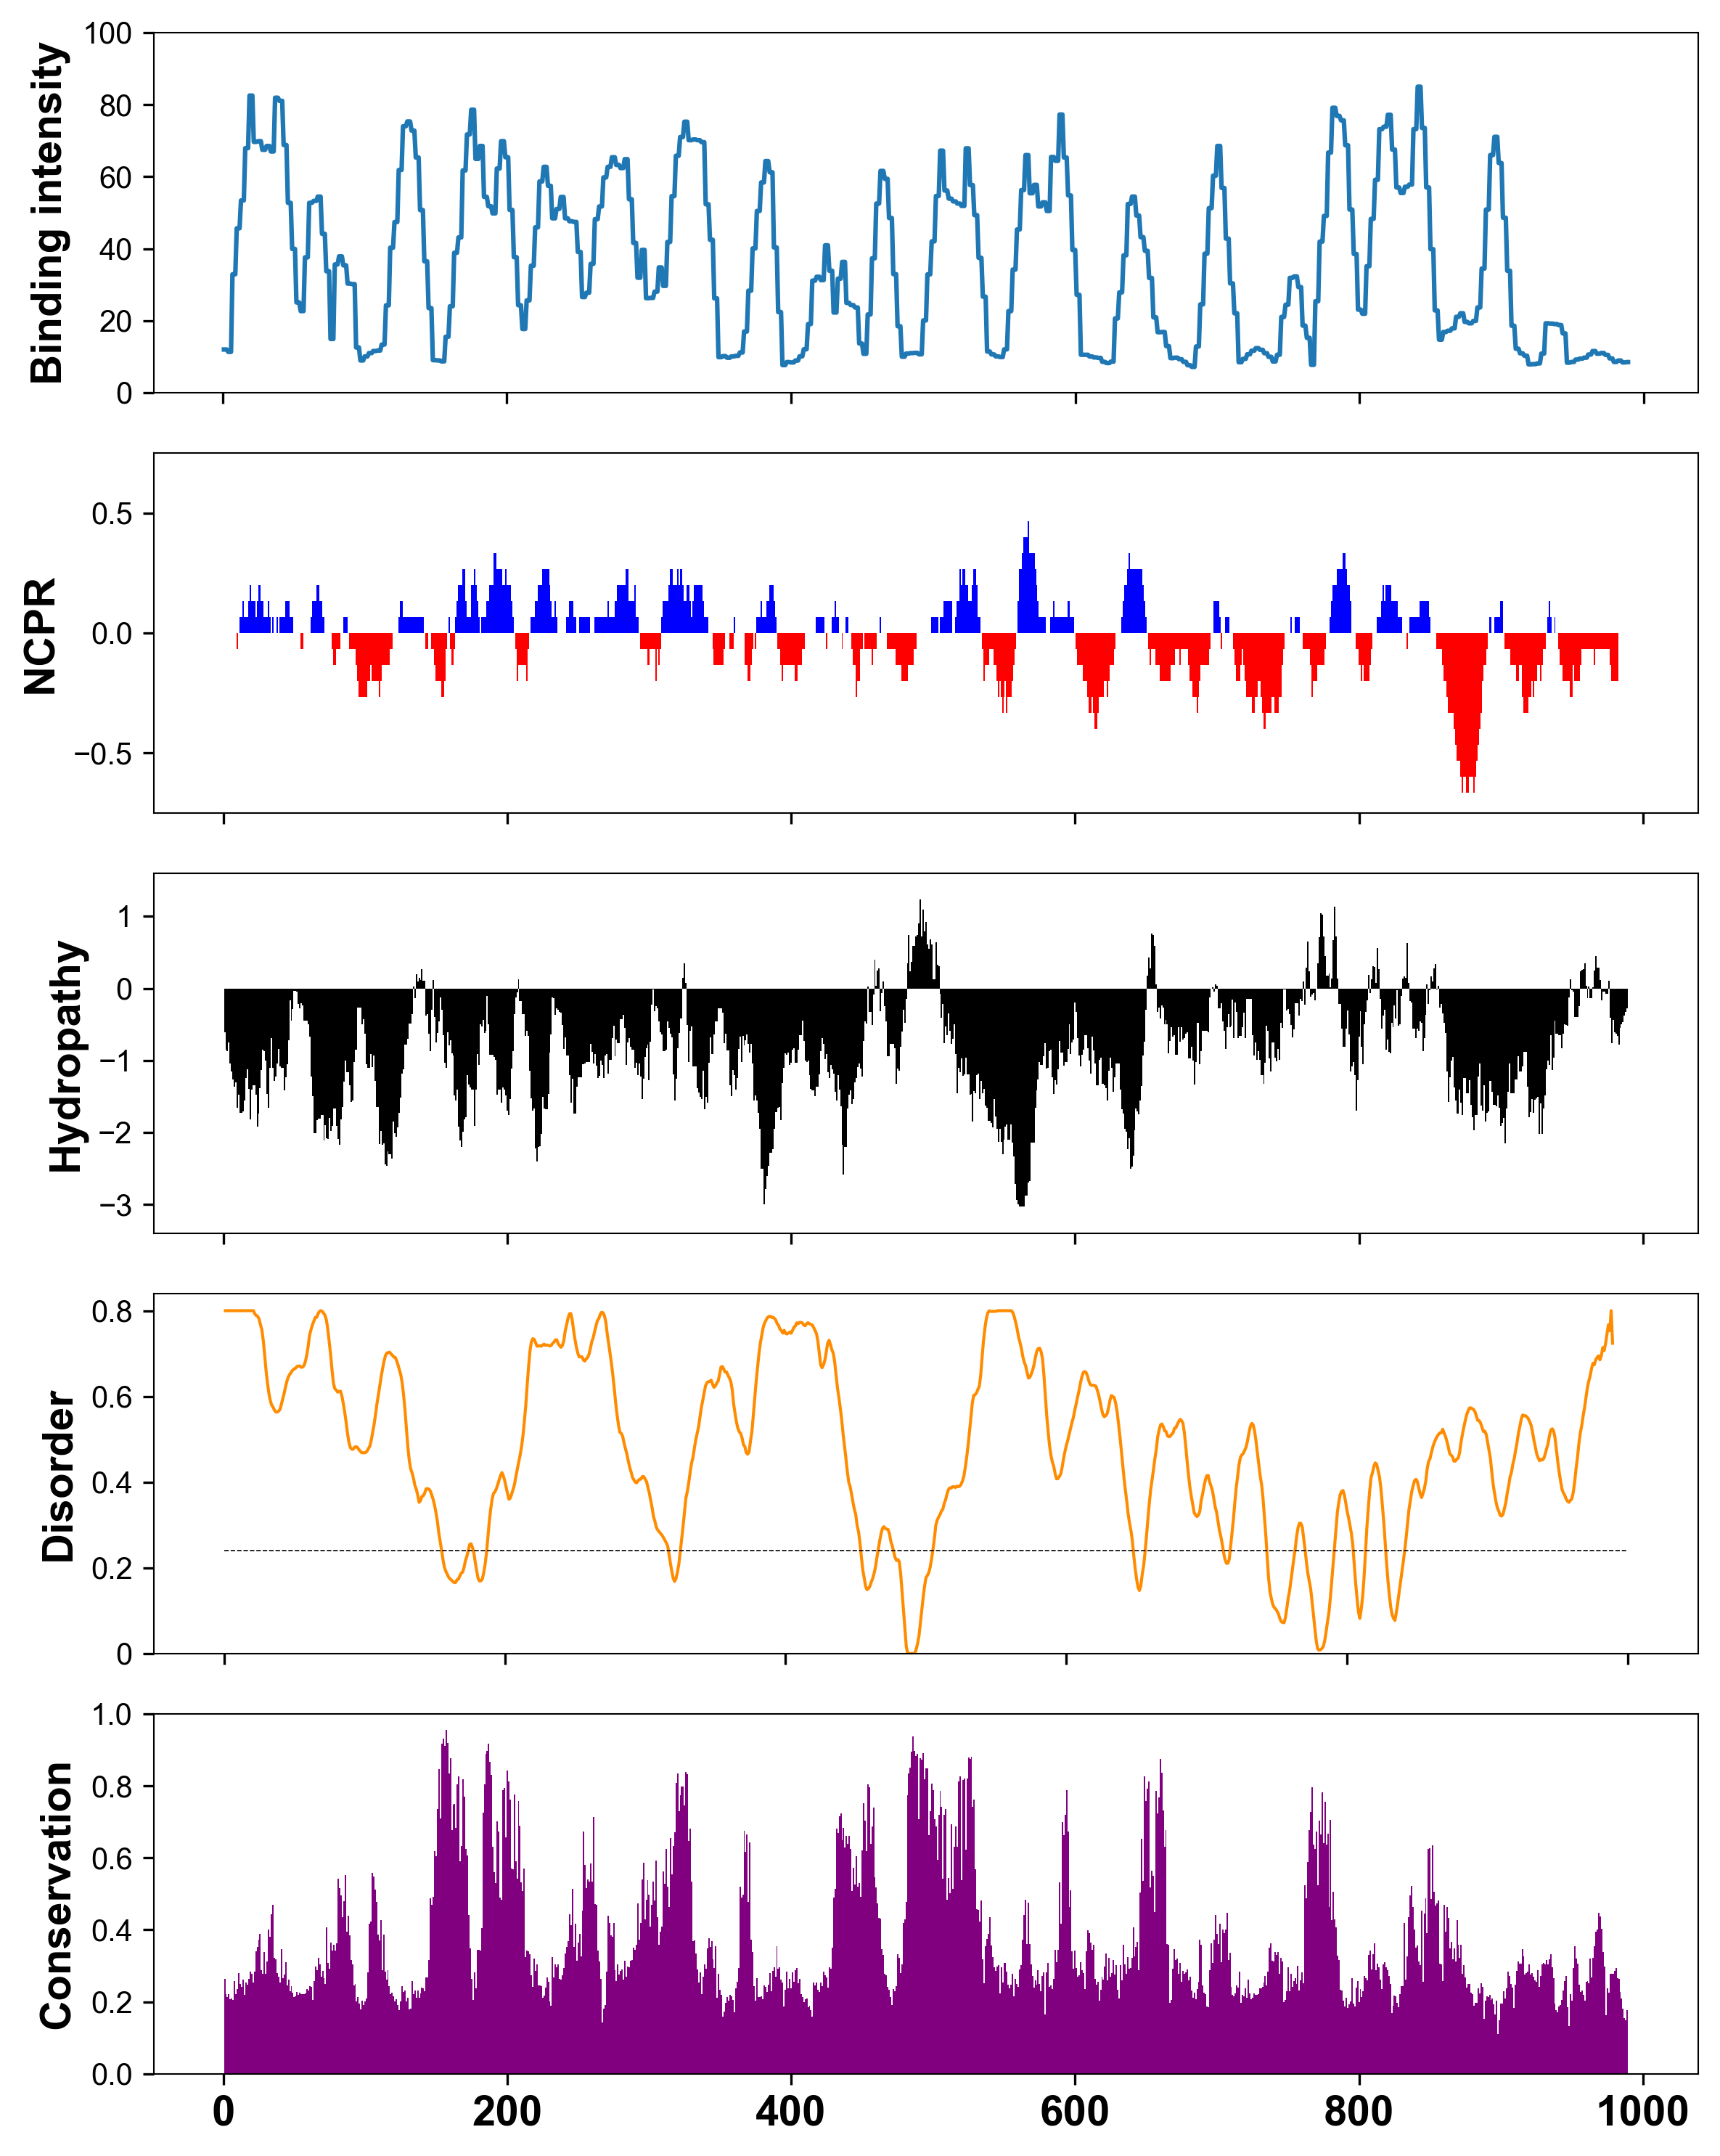

In [14]:
# Plot
fig, axs = plt.subplots(5,1, figsize=(8, 10), dpi=300)
ax1, ax2, ax3, ax4, ax5 = axs

# Avg binding over sequence
ax1.plot(domain, avg_binding)
ax1.set_ylabel('Binding intensity', fontweight='bold', fontsize=14)
ax1.set_ylim([0, 100])
ax1.set_xticklabels([])

# NCPR sliding window (window length=15)
seqOb = SequenceParameters(FRQ)
linNCPR = seqOb.get_linear_NCPR(blobLen=15)

positive_data = [x if x > 0 else 0 for x in linNCPR[1]]
negative_data = [x if x < 0 else 0 for x in linNCPR[1]]

ax2.bar(domain, negative_data, width=1, color='r')
ax2.bar(domain, positive_data, width=1, color='b')
ax2.set_ylim([-0.75, 0.75])
ax2.set_ylabel('NCPR', fontweight='bold', fontsize=14)
ax2.set_xticklabels([])

# Kyte-Doolittle hydropathy
ax3.bar(domain, sliding_window_KDhydropathy(FRQ, 15),  width=1, color='k')
ax3.set_ylim([-3.4, 1.6])
ax3.set_ylabel('Hydropathy', fontweight='bold', fontsize=14)
ax3.set_xticklabels([])

# Disorder
ax4.plot(np.arange(1,len(b.target_sequence)+1), smooth_disorder, color='darkorange', linewidth=1)
ax4.plot([0, 1000], [0.3]*2, 'k--', linewidth=0.4)
ax4.set_ylim([0, 1.05])
ax4.set_ylabel('Disorder', fontweight='bold', fontsize=14)
ax4.set_xticklabels([])
ax4.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

# Conservation
ax5.bar(np.arange(1,len(b.target_sequence)+1), b.target_normalized_scores, color='purple',width=1)
ax5.set_ylim([0, 1])
ax5.set_ylabel('Conservation', fontweight='bold', fontsize=14)
ax5.set_xticklabels([0, 0, 200, 400, 600, 800, 1000], fontweight='bold', fontsize=14)

plt.tight_layout()
# plt.savefig('FigS1A_and_Fig3A')
plt.show()

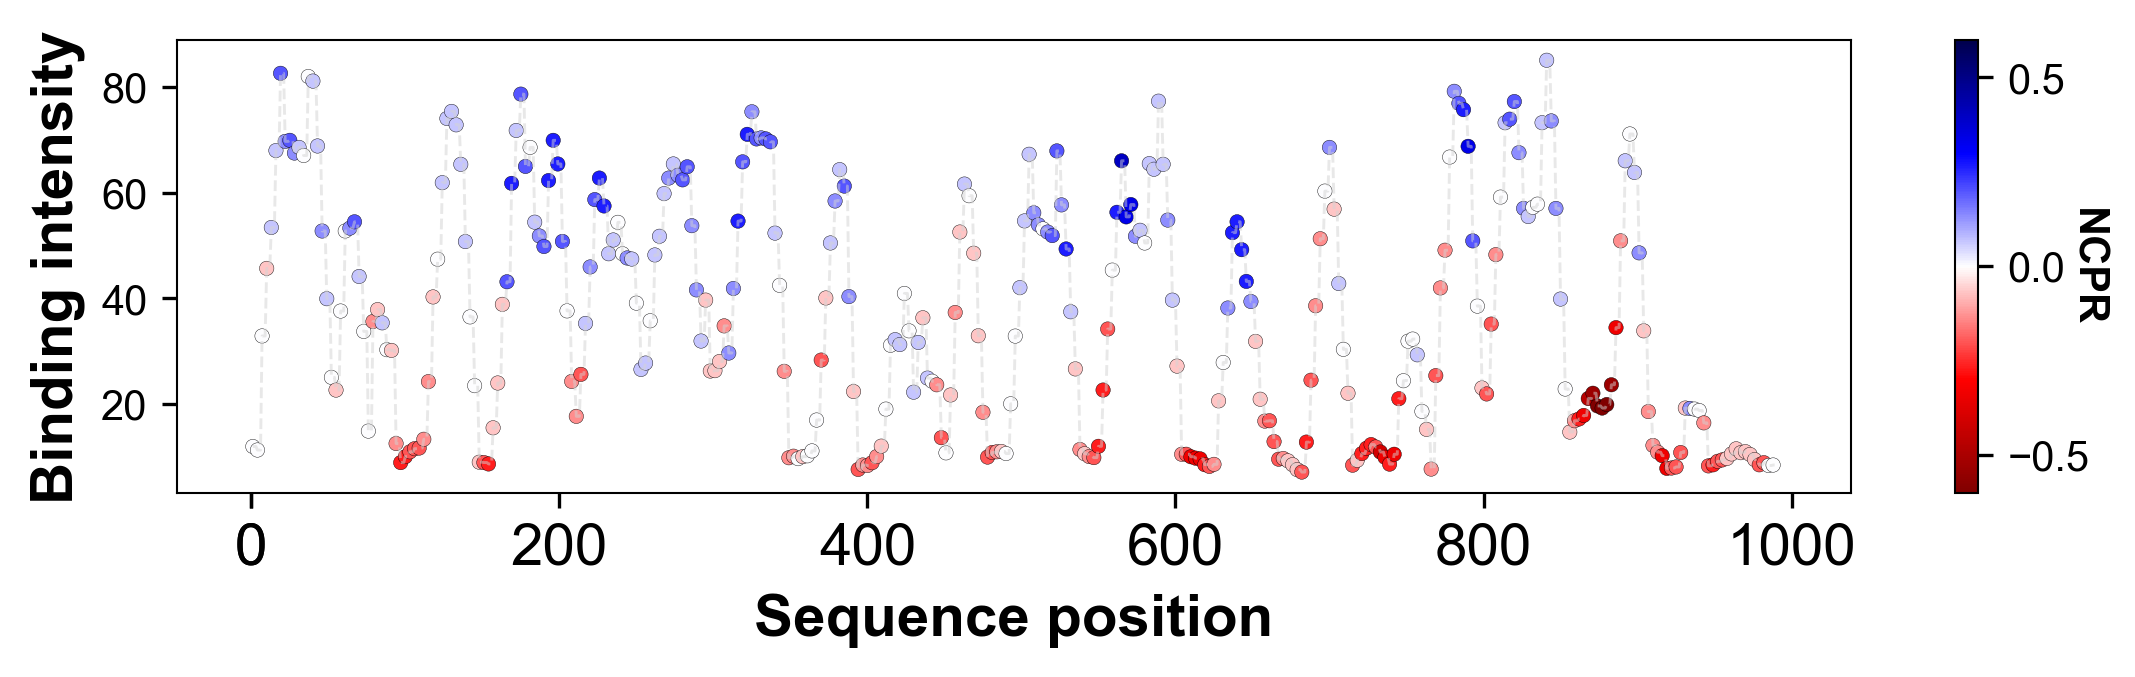

In [15]:
# Fig 3A: affinities combined with NCPR
plt.figure(figsize=(9, 2), dpi=300)
# Avg binding over sequence
plt.scatter(domain[0::3], avg_binding[0::3], c=linNCPR[1][0::3], s=12, cmap='seismic_r', edgecolor='k', linewidth=0.1, vmin=-0.6, vmax=0.6)
plt.plot(domain, avg_binding, color='lightgray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.ylabel('Binding intensity', fontweight='bold', fontsize=14)
plt.xticks([0, 0, 200, 400, 600, 800, 1000], fontsize=14)
plt.xlabel('Sequence position', fontweight='bold', fontsize=14)
cbar = plt.colorbar()
cbar.set_ticks([-0.5,0,0.5])
cbar.set_label('NCPR', rotation=270, fontsize=10, fontweight='bold')
#plt.savefig('S3A_affinity_NCPR')
plt.show()

## FRQ inverse-weighted distance (IWD) residue clustering
* Figure 3B
* Supplemental figures 2A-B

In [17]:
# Helper functions
def map_seq_mask(seq, res):
    """
    this function maps the sequence into a vector
    
    res as list of aa: e.g., ['F', 'Y', 'W']
    
    Input: string sequence 
    Output: a 1 or 0  vector as array matched to string legnth
    """
    mask_res = {}
    for aa in res:
        mask_res[aa] = 1
    
    mask = [0] * len(seq)
    
    # iterate sequence and edit mask
    for i,j in enumerate(seq):
        if j in mask_res:
            mask[i]= mask_res[j]

    return mask

# ------------------------------------------------------------------

def find_all_indicies(test_list, A):
    """
    A = list 
    B = value 
    Returns list of start positions where stringA is in stringB - including overlaps 
    """
    return [i for i, value in enumerate(test_list) if value == A]

# ------------------------------------------------------------------

def calc_average_inverse_distance(seq, res):
    """
    returns average IWD value
    """
    mask = map_seq_mask(seq, res)
    
    # dictionary of empty values for each index point
    all_hits = {i:0 for i in find_all_indicies(mask, 1)} 
    hits = np.array([i for i in all_hits.keys()])
    
    # iterate through index
    for i, p in enumerate(hits):
        resi_distances= 0
        # iterate through pairs for that index 
        for p1 in hits[np.arange(len(hits))!=i]:
            resi_distances += 1 / np.abs(p1-p)

        all_hits[p] = resi_distances
        #print(p,resi_distances)
    
    if len(hits) > 0:
        return sum(all_hits.values())/len(hits)
    else:
        return 0 

# ------------------------------------------------------------------

def shuffle_seq(s):
    """
    Returns a shuffled version of the sequence
    """
    return ''.join(random.sample(s,len(s)))

# ------------------------------------------------------------------

def iwd_aliphatics(s):
    return calc_average_inverse_distance(s, ['M', 'I', 'L', 'V'])

def iwd_aromatics(s):
    return calc_average_inverse_distance(s, ['F', 'Y', 'W'])

def iwd_positives(s):
    return calc_average_inverse_distance(s, ['R', 'K', 'H'])

def iwd_negatives(s):
    return calc_average_inverse_distance(s, ['D', 'E'])

def calc_delta(s):
    return SequenceParameters(s).SeqObj.delta()

# ------------------------------------------------------------------

def calc_dist_and_zscore(seq, func, N=10000):
    """
    Calculates the WT value, computes the value for N shuffled variants,
    and calculates the Z-score
    """
    # Calculate function for target sequence
    target_val = func(seq)
    
    # Get distribution of values for shuffled sequences
    vals = []
    for loop in range(N):
        random_seq = shuffle_seq(seq)       
        vals.append(func(random_seq))
    
    # Get z-score
    z_score = (target_val - np.mean(vals)) / np.std(vals)
        
    return (target_val, z_score, vals)


In [ ]:
# Positive residue IWD clustering
FRQ_pcluster, pc_zscore, pc_dist = calc_dist_and_zscore(FRQ, iwd_positives, N=10000)

## NOTE: these function takes a while to run and z-score and distribution may change slightly across runs

In [ ]:
# Figure 3B
plt.figure(figsize=(3,3), dpi=300)
plt.hist(pc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_pcluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.title('Positive residue clustering', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.xlabel('IWD', fontweight='bold')
plt.text(2.16, 2.2, f'z-score\n= {round(pc_zscore, 2)}', fontsize=8)
plt.legend()

#plt.savefig('Fig3B')
plt.show()

In [ ]:
# Negative residue IWD clustering
FRQ_ncluster, nc_zscore, nc_dist = calc_dist_and_zscore(FRQ, iwd_negatives, N=10000)

In [ ]:
# Supplemental figure 2A
plt.figure(figsize=(3,3), dpi=300)
plt.hist(nc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_ncluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.xlabel('IWD', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.title('Negative residue clustering', fontweight='bold')
plt.text(2.1, 2.2, f'z-score\n= {round(nc_zscore, 2)}', fontsize=8)
plt.legend()

# plt.savefig('FigS2A')
plt.show()

In [ ]:
# Aromatic residue IWD clustering
FRQ_aromcluster, aromc_zscore, aromc_dist = calc_dist_and_zscore(FRQ, iwd_aromatics, N=10000)

In [ ]:
# Supplemental figure 2B
plt.figure(figsize=(3,3), dpi=300)
plt.hist(aromc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_aromcluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.xlabel('IWD', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.title('Aromatic residue clustering', fontweight='bold')
plt.text(0.78, 2.2, f'z-score\n= {round(aromc_zscore, 2)}', fontsize=8)
plt.legend()

# plt.savefig('FigS2B')
plt.show()

## Ortholog IWD comparisons
* Figure 3C
* Supplemental figure 3A

In [31]:
# Ortholog sequences and pre-computed IWDs
# TODO: change paths
per_ortholog_seqs = protfasta.read_fasta('data/per_orthologs.fasta')
fungal_ortholog_seqs = protfasta.read_fasta('data/fungal_orthologs.fasta')
per_ortholog_IWDs = pd.read_csv('data/per_orthologs_iwd_zscores.csv')
fungal_ortholog_IWDs = pd.read_csv('data/fungal_orthologs_iwd_delta_zscores.csv')

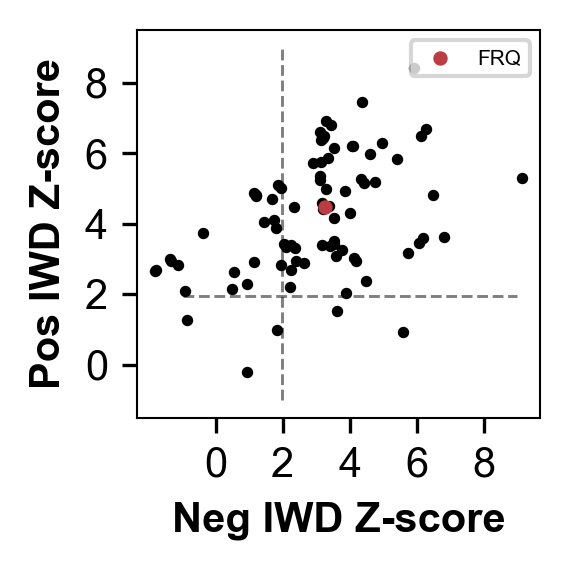

In [39]:
# Figure S3A: FRQ and fungal orthologs
x = fungal_ortholog_IWDs['neg_clust'].values
y = fungal_ortholog_IWDs['pos_clust'].values

plt.figure(figsize=(2,2), dpi=300)
plt.scatter(x[:-1], y[:-1], s=3, color='k')
plt.scatter(x[-1], y[-1], s=6, color='#BC3C41', label='FRQ')
plt.hlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
plt.vlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
plt.xlabel('Neg IWD Z-score', fontweight='bold')
plt.ylabel('Pos IWD Z-score', fontweight='bold')
plt.xticks([0,2,4,6,8])
plt.yticks([0,2,4,6,8])

plt.legend(loc='upper right', fontsize=5)
plt.tight_layout()

# plt.savefig('S3A')
plt.show()

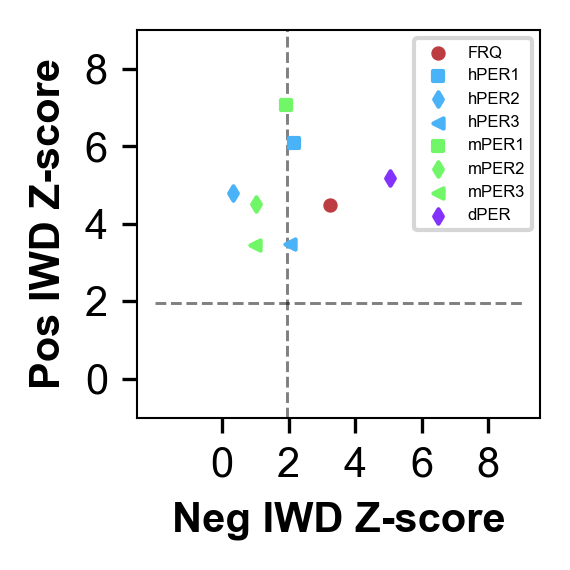

In [41]:
# Figure 3C: FRQ and PER orthologs
fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300)

per_pos = per_ortholog_IWDs['pos_IWD'].values
per_neg = per_ortholog_IWDs['neg_IWD'].values
plt.scatter(x[-1], y[-1], s=6, color='#BC3C41', label='FRQ', zorder=3)
ax.scatter(per_neg[0], per_pos[0], marker='s', color='#4AB2F6', s=6, label='hPER1', zorder=3)
ax.scatter(per_neg[1], per_pos[1], marker='d', color='#4AB2F6', s=6, label='hPER2', zorder=3)
ax.scatter(per_neg[2], per_pos[2], marker='<', color='#4AB2F6', s=6, label='hPER3', zorder=3)
ax.scatter(per_neg[3], per_pos[3], marker='s', color='#70F667', s=6, label='mPER1', zorder=3)
ax.scatter(per_neg[4], per_pos[4], marker='d', color='#70F667', s=6, label='mPER2', zorder=3)
ax.scatter(per_neg[5], per_pos[5], marker='<', color='#70F667', s=6, label='mPER3', zorder=3)
ax.scatter(per_neg[6], per_pos[6], marker='d', color='#8331FC', s=6, label='dPER', zorder=3)

ax.set_ylim([-1,9])
ax.hlines(1.96, -2, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5, zorder=1)
ax.vlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5, zorder=1)
ax.set_xlabel('Neg IWD Z-score', fontweight='bold')
ax.set_ylabel('Pos IWD Z-score', fontweight='bold')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,2,4,6,8])

plt.tight_layout()
ax.legend(fontsize=4)

# plt.savefig('Fig3C')
plt.show()

## FFD point mutant table
* Figure 4D

In [43]:
# load data
table = np.loadtxt('data/ffd_mutant_table.tsv', dtype='str')
ffd = table[0, 1:]
AAs = table[1:, 0]
table = np.genfromtxt([v.replace('*', 'np.nan') for v in table[1:, 1:].flatten()]).reshape(20, 15)
table = table * 64 / 100 + 64

In [44]:
log_table = np.log2(table / 64)

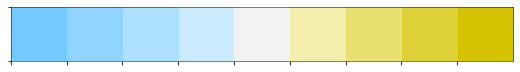

In [47]:
sns.palplot(sns.diverging_palette(235, 78, s=100, l=78, sep=2, n=9))
cmap = sns.diverging_palette(235, 78, s=100, l=78, sep=2, n=9, as_cmap=True)

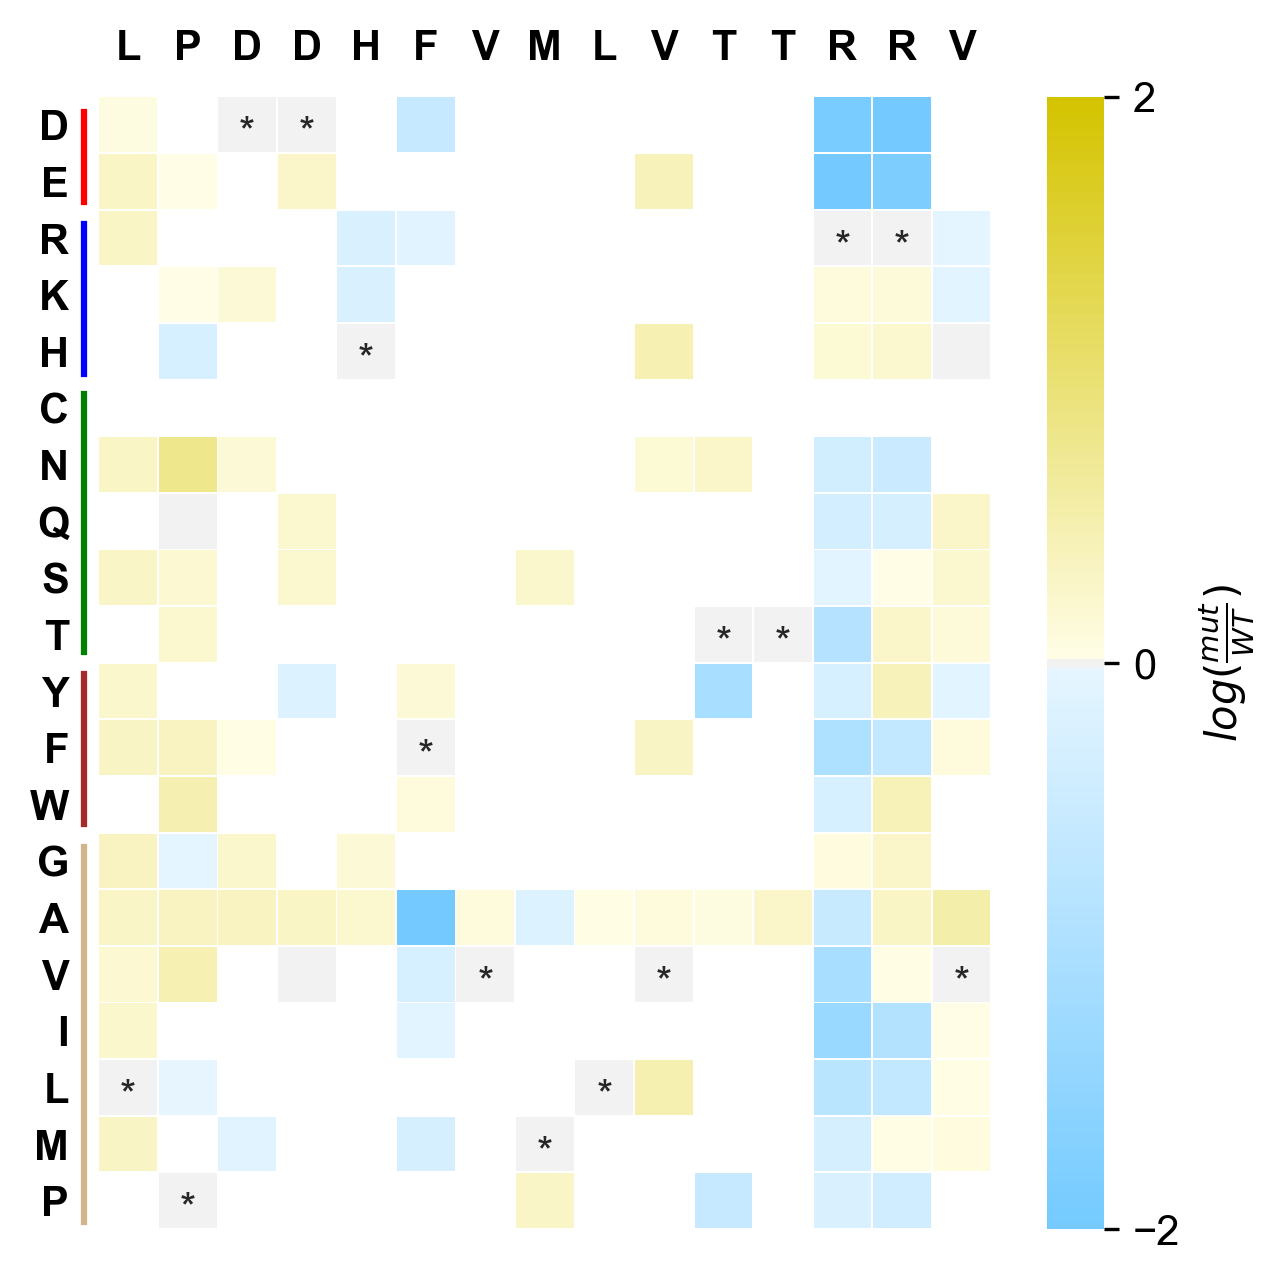

In [50]:
fig = plt.figure(figsize=(4.8,5), dpi=300)

labels = np.full((20, 15), fill_value='')
for loc in [(17,0),(19,1),(0,2),(0,3),(4,4),(11,5),(15,6),(18,7),(17,8),(15,9),(9,10),(9,11),(2,12),(2,13),(15,14)]:
    labels[loc[0], loc[1]] = '*'

fig.add_artist(lines.Line2D([0.115, 0.115], [0.87, 0.81], c='r'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.795, 0.695], c='b'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.682, 0.51], c='g'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.495, 0.395], c='brown'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.38, 0.13], c='tan'))

akws = {"va": 'bottom'}
ax = sns.heatmap(log_table, vmin=-2, vmax=2, center=0, cmap=cmap, linewidth=0.2, 
                 annot=labels, fmt='', annot_kws=akws, cbar_kws={"ticks":[-2,0,2], "label" : r'$log(\frac{mut}{WT})$'})
ax.xaxis.tick_top()
ax.set_xticklabels(ffd, fontweight='bold')
ax.set_yticklabels(AAs, rotation=0, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, 
                top = False, labeltop=True, left=False)

for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0, 0.5,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


# plt.savefig('Figure4D')
plt.show()